In [ ]:
import liionpack as lp
import pybamm
import numpy as np

# Define a different model, e.g., the Single Particle Model (SPM)
model = pybamm.lithium_ion.SPM()

# Set up the parameter values
parameter_values = pybamm.ParameterValues("Chen2020")

# Define the cycling experiment
experiment = pybamm.Experiment([
    "Charge at 1 C for 60 minutes",
    "Discharge at 1 C for 60 minutes"
])

# Create the netlist for the battery pack
netlist = lp.setup_circuit(Np=16, Ns=2, Rb=1e-4, Rc=1e-2, Ri=5e-2, V=3.2, I=80.0)

# Initialize liionpack with the custom model
sim = lp.Simulation(
    model=model, 
    experiment=experiment, 
    parameter_values=parameter_values, 
    netlist=netlist
)
sim.solve()
# Run the simulation
output_variables = [
    'X-averaged total heating [W.m-3]',
    'Volume-averaged cell temperature [K]',
    'X-averaged negative particle surface concentration [mol.m-3]',
    'X-averaged positive particle surface concentration [mol.m-3]'
]


# Process the results
print(results)


In [ ]:
import liionpack as lp

# Configure Liionpack to use the custom model
lp_model = lp.Liionpack(model=model)


Stepping simulation:  98%|███████████████████████████████████████████████████████████████████████████████████████████▋  | 3511/3600 [00:44<00:00, 91.43it/s]Event: Maximum voltage [V], Batteries: [0, 1, 2, 3, 4, 5]
High voltage limit reached
Stepping simulation:   0%|                                                                                                          | 0/600 [00:00<?, ?it/s]High voltage limit reached
Event: Maximum voltage [V], Batteries: [0, 1, 2, 3, 4, 5]
Stepping simulation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:01<00:00, 67.23it/s]


{'Time [s]': array([0.000e+00, 1.000e+01, 2.000e+01, ..., 5.737e+04, 5.738e+04,
       5.739e+04], dtype=float32), 'Pack current [A]': array([2.5, 2.5, 2.5, ..., 0. , 0. , 0. ], dtype=float32), 'Pack terminal voltage [V]': array([12.4200325, 12.392308 , 12.3748   , ..., 12.566664 , 12.566656 ,
       12.566649 ], dtype=float32), 'Cell current [A]': array([[ 1.2509651e+00,  1.2509651e+00,  1.2509651e+00,  1.2490349e+00,
         1.2490349e+00,  1.2490349e+00],
       [ 1.2508557e+00,  1.2508557e+00,  1.2508557e+00,  1.2491443e+00,
         1.2491443e+00,  1.2491443e+00],
       [ 1.2507690e+00,  1.2507690e+00,  1.2507690e+00,  1.2492310e+00,
         1.2492310e+00,  1.2492310e+00],
       ...,
       [ 4.6399837e-06,  4.6399837e-06,  4.6399837e-06, -4.6397749e-06,
        -4.6397749e-06, -4.6397749e-06],
       [ 4.6399837e-06,  4.6399837e-06,  4.6399837e-06, -4.6397749e-06,
        -4.6397749e-06, -4.6397749e-06],
       [ 4.6399837e-06,  4.6399837e-06,  4.6399837e-06, -4.6397749e-06,


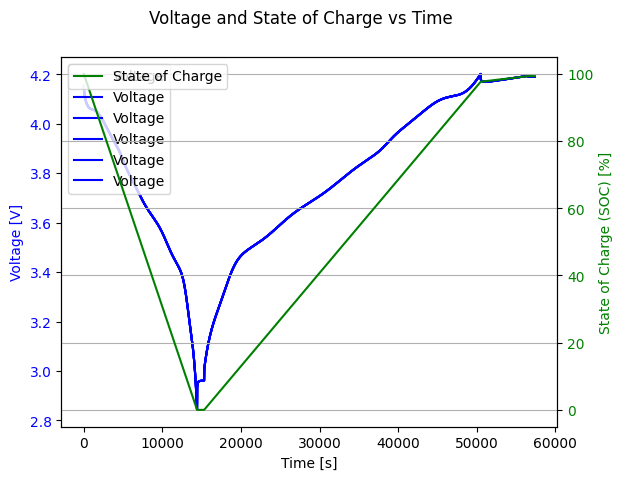

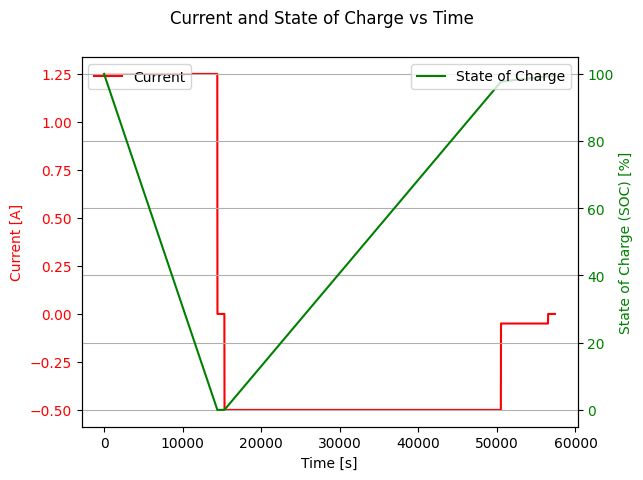

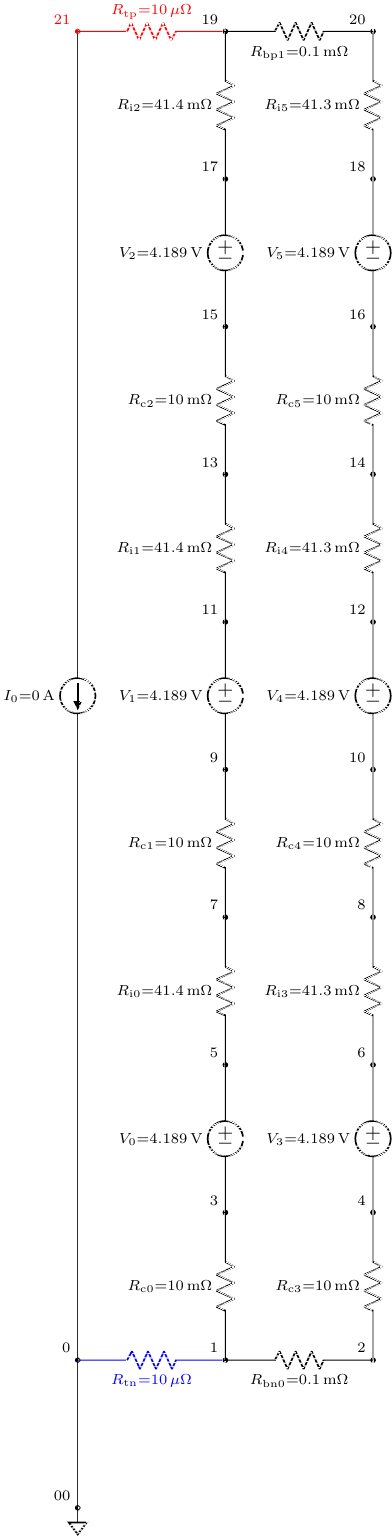

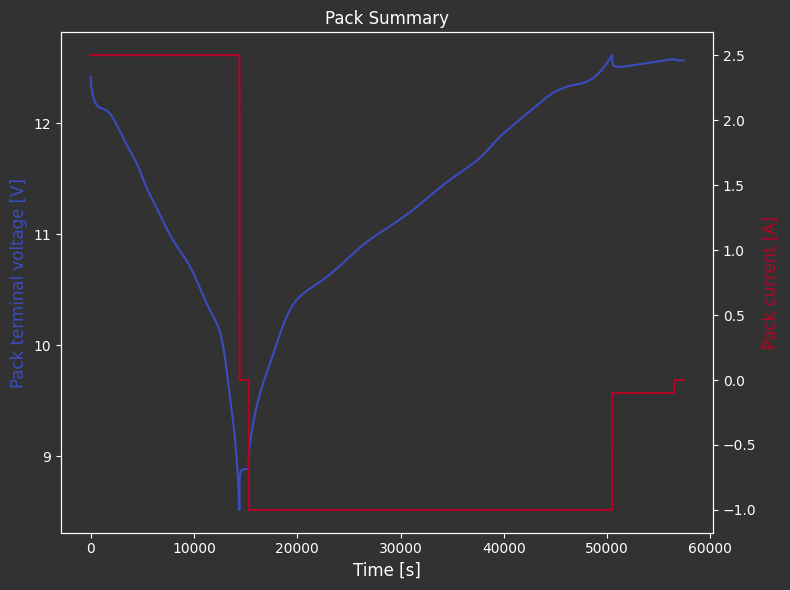

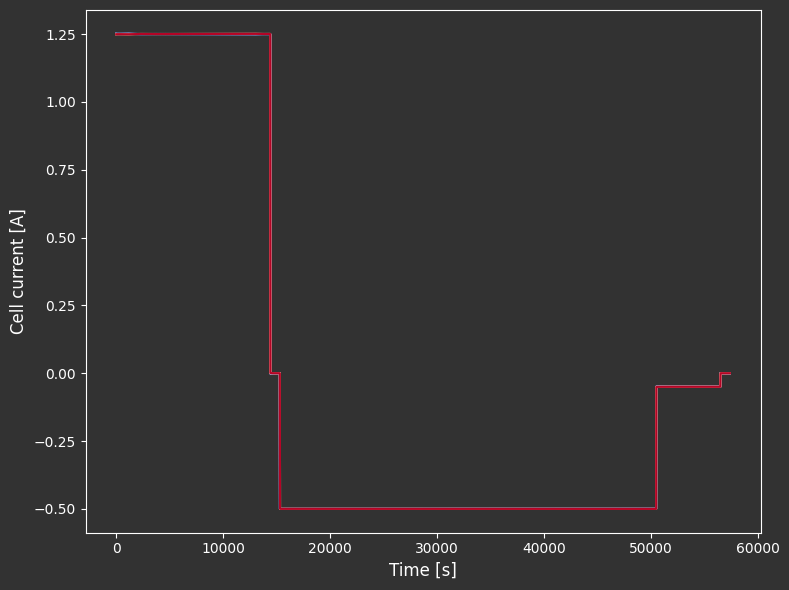

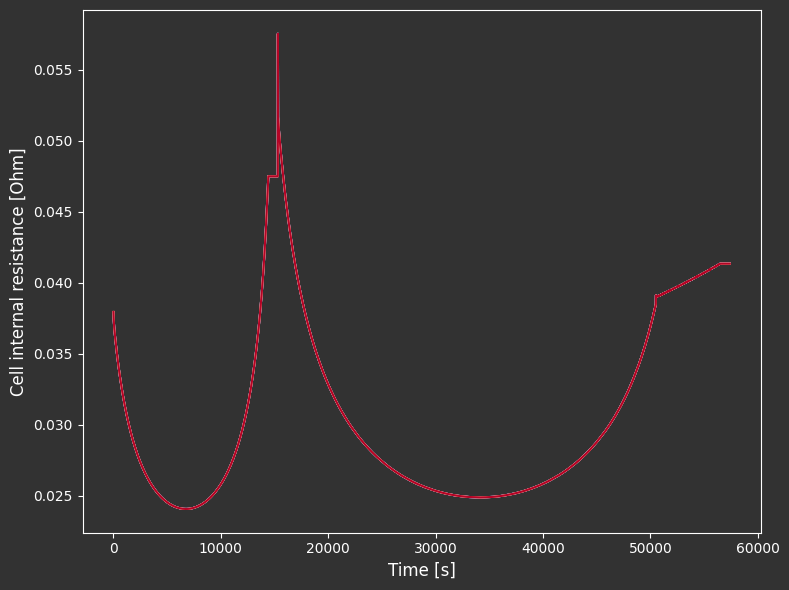

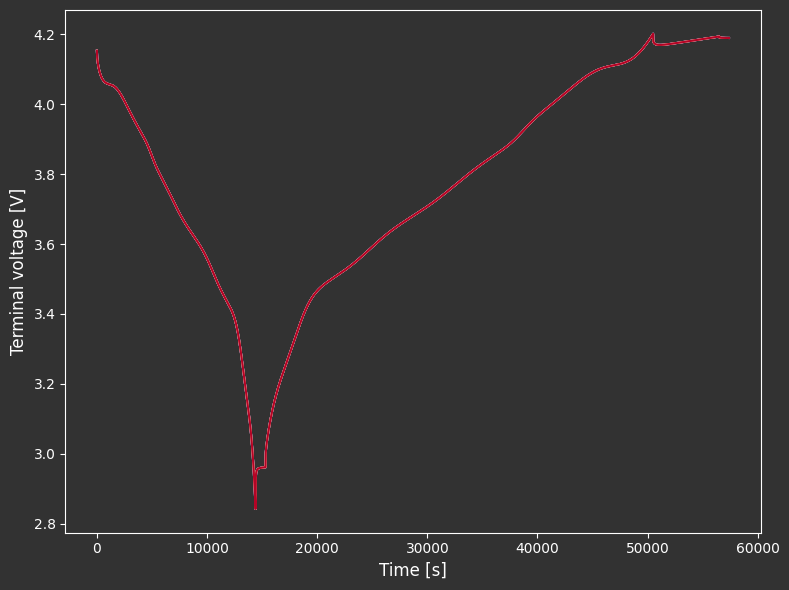

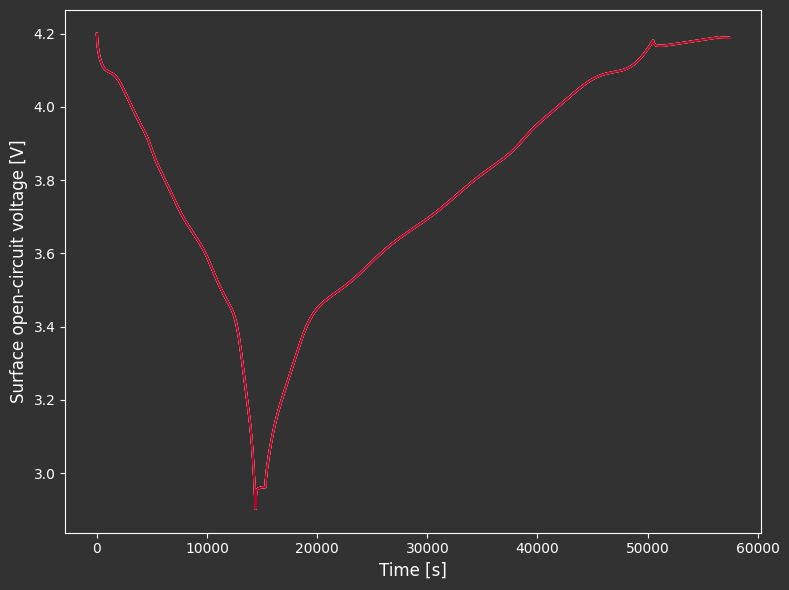

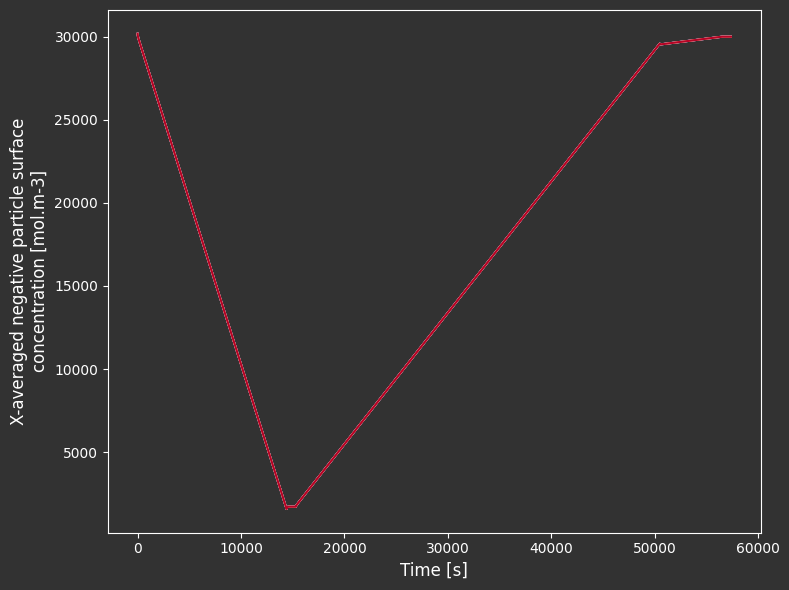

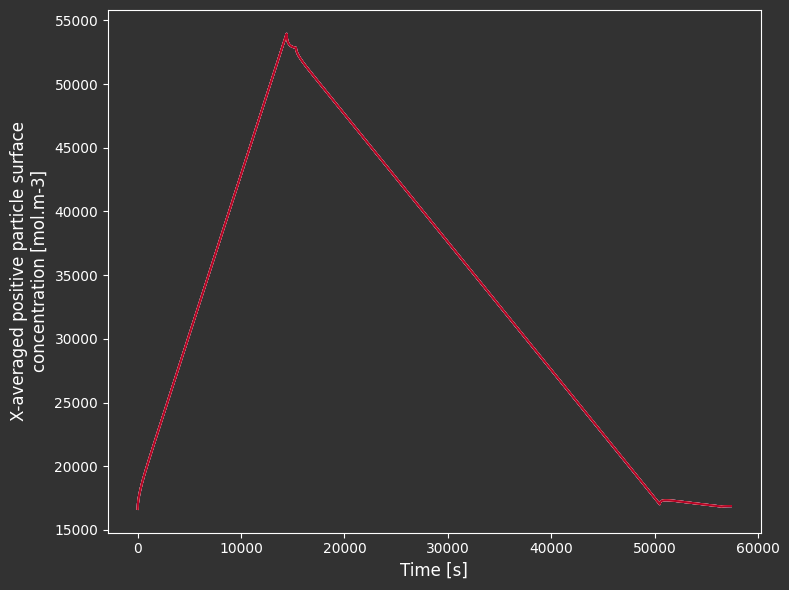

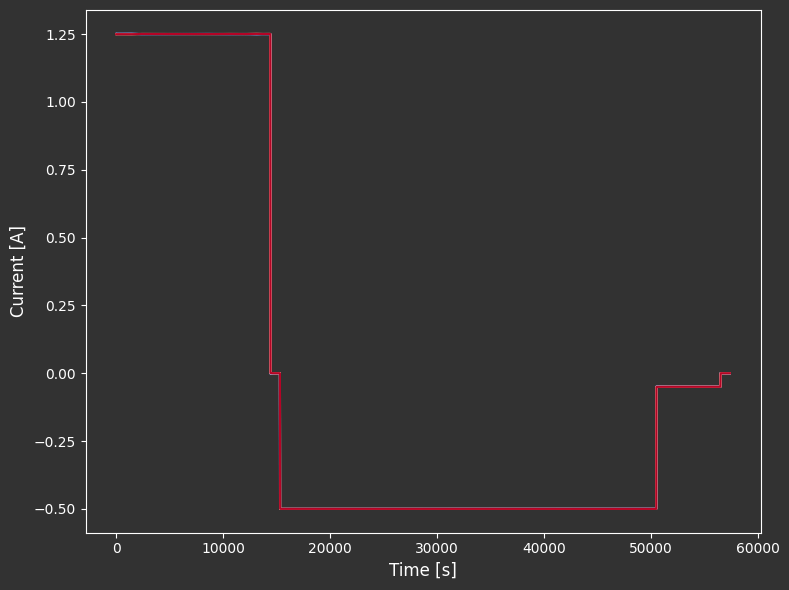

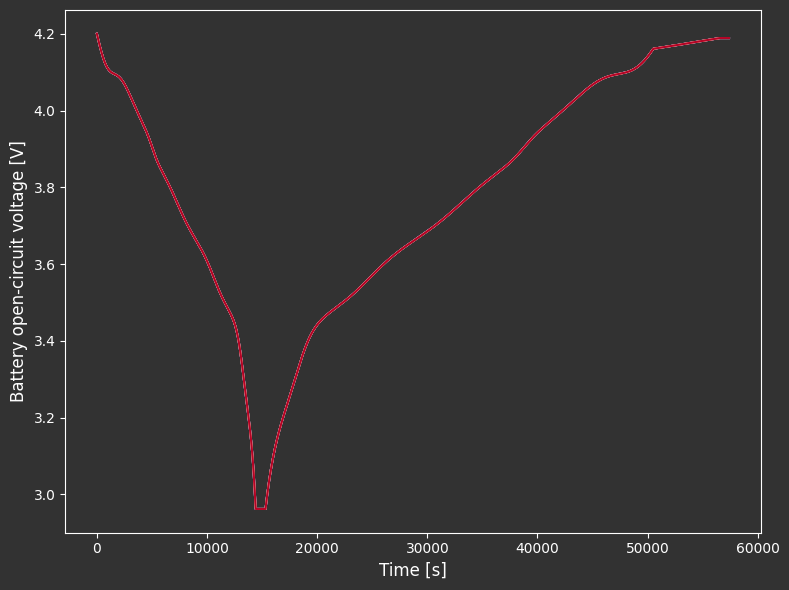

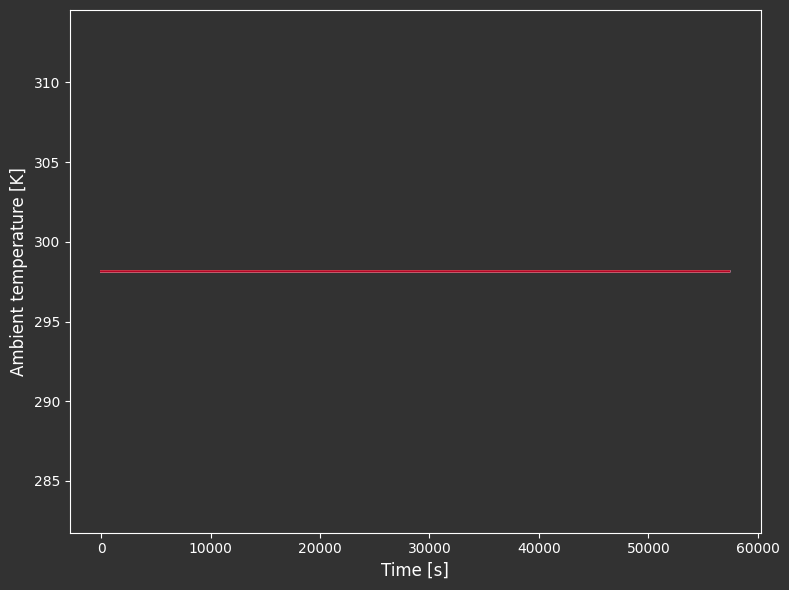

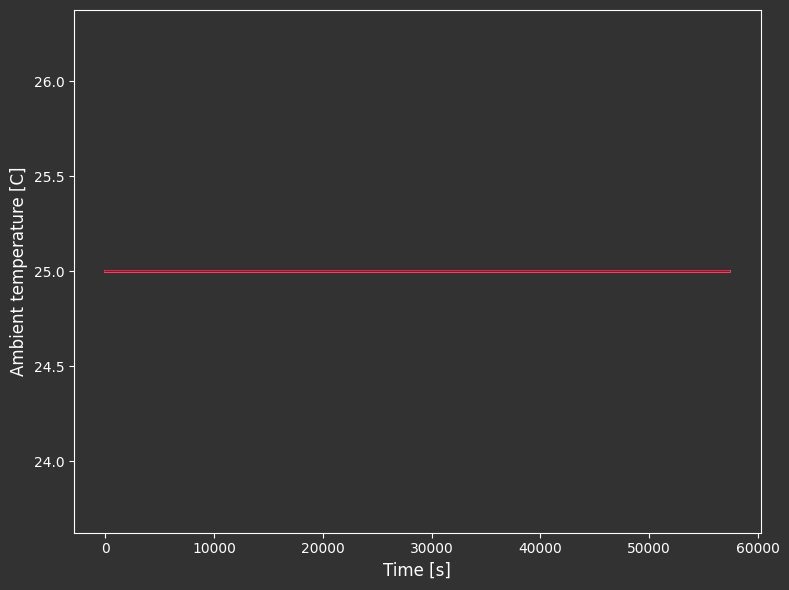

In [31]:
import pybamm
import numpy as np
import liionpack as lp
import matplotlib.pyplot as plt

def basic_simulation(parameter_values=None):
    # Create the pybamm model
    model = pybamm.lithium_ion.SPM()

    # Add events to the model
    model = lp.add_events_to_model(model)

    # Set up parameter values
    if parameter_values is None:
        param = pybamm.ParameterValues("Chen2020")
    else:
        param = parameter_values.copy()

    # Set up solver and simulation
    solver = pybamm.CasadiSolver(mode="safe")
    sim = pybamm.Simulation(
        model=model,
        parameter_values=param,
        solver=solver,
    )
    return sim

# Generate the netlist
netlist = lp.setup_circuit(Np=2, Ns=3, Rb=1e-4, Rc=1e-2, Ri=5e-2, V=1.5, I=80.0)

# Define the parameter values
parameter_values = pybamm.ParameterValues("Chen2020")

# Define the experiment
experiment = pybamm.Experiment(
    [
        "Discharge at 2.5 A for 240 minutes",
        "Rest for 15 minutes",
        "Charge at 1 A for 600 minutes",
        "Charge at 100 mA for 100 minutes",
        "Rest for 15 minutes",
    ],
    period="10 seconds",
)

# Define the output variables
output_variables = [
    "X-averaged negative particle surface concentration [mol.m-3]",
    "X-averaged positive particle surface concentration [mol.m-3]",
    "Terminal voltage [V]",
    "Current [A]",
    "Battery open-circuit voltage [V]",
    "Ambient temperature [K]",
    # "Cell temperature [K]",
    "Ambient temperature [C]",
    # "Cell temperature [C]",
]

InitialSoC = 1.0

# Solve the pack using the custom simulation function
output = lp.solve(
    netlist=netlist,
    parameter_values=parameter_values,
    experiment=experiment,
    sim_func=basic_simulation,
    output_variables=output_variables,
    initial_soc=InitialSoC
)

print(output)

# Extract data for manual SoC calculation
time = output["Time [s]"]
current = output["Current [A]"].mean(axis=1)  # Average current across cells

# Extract battery capacity from the parameter values
battery_capacity_Ah = parameter_values["Nominal cell capacity [A.h]"]

# Convert battery capacity to amp-seconds (As)
battery_capacity_As = battery_capacity_Ah * 3600

# Calculate cumulative charge in ampere-seconds (As)
cumulative_charge_As = np.cumsum(current * np.diff(np.insert(time, 0, 0)))

# Calculate SoC as a percentage
initial_soc_as = InitialSoC * battery_capacity_As
soc = (initial_soc_as - cumulative_charge_As) / battery_capacity_As * 100

# Print the last SoC value
print("Last State of Charge (SoC) value: {:.2f}%".format(soc[-1]))

# Function to plot voltage and SoC
def plot_voltage_soc(output, soc):
    time = output["Time [s]"]
    voltage = output["Terminal voltage [V]"]

    # Plot voltage and SoC vs time on the same graph
    fig, ax1 = plt.subplots()

    ax1.plot(time, voltage, 'b-', label='Voltage')
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Voltage [V]', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()  # Instantiate a second y-axis that shares the same x-axis
    ax2.plot(time, soc, 'g-', label='State of Charge')
    ax2.set_ylabel('State of Charge (SOC) [%]', color='g')
    ax2.tick_params(axis='y', labelcolor='g')

    # Adding a title and legend
    fig.suptitle('Voltage and State of Charge vs Time')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')

    plt.grid(True)
    plt.show()

# Function to plot current and SoC
def plot_current_soc(output, soc):
    time = output["Time [s]"]
    current = output["Current [A]"].mean(axis=1)  # Average current across cells

    # Plot current and SoC vs time on the same graph
    fig, ax1 = plt.subplots()

    ax1.plot(time, current, 'r-', label='Current')
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Current [A]', color='r')
    ax1.tick_params(axis='y', labelcolor='r')

    ax2 = ax1.twinx()  # Instantiate a second y-axis that shares the same x-axis
    ax2.plot(time, soc, 'g-', label='State of Charge')
    ax2.set_ylabel('State of Charge (SOC) [%]', color='g')
    ax2.tick_params(axis='y', labelcolor='g')

    # Adding a title and legend
    fig.suptitle('Current and State of Charge vs Time')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.grid(True)
    plt.show()

# Plot the standard output, voltage/SoC graph, and current/SoC graph
plot_voltage_soc(output, soc)
plot_current_soc(output, soc)
lp.plot_output(output)

# Draw the circuit
lp.draw_circuit(netlist, cpt_size=1.0, dpi=150, node_spacing=2.5)
plt.show()

In [ ]:
!pip install scikits.odes
